In [3]:
! pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph bs4


In [41]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "CodeAssistant"
_set_env("OPENAI_API_KEY")
# _set_env("ANTHROPIC_API_KEY")

In [42]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [52]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."


expt_llm = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
# solution = code_gen_chain_oai.invoke({"context":concatenated_content,"messages":[("user",question)]})

In [44]:
# # Test
# question = "How do I build a RAG chain in LCEL?"
# solution = code_gen_chain.invoke(
#     {"context": concatenated_content, "messages": [("user", question)]}
# )
# solution

In [45]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

In [60]:
from langchain_core.pydantic_v1 import BaseModel, Field

### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state.get("error", "no")


    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [61]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()


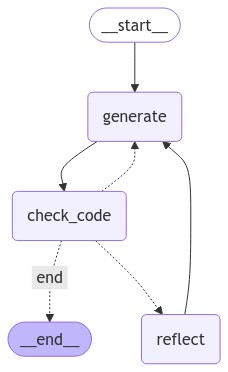

In [62]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [63]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
app.invoke({"messages": [("user", question)], "iterations": 0})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---


{'error': 'yes',
 'messages': [('user',
   'How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?'),
  ('assistant',
   'This code demonstrates how to directly pass a string to a runnable in LangChain and use it to construct the input for a prompt. The example uses a simple prompt template that takes a user input string and formats it into a prompt for a language model. \n Imports: from langchain_core.prompts import PromptTemplate\nfrom langchain_core.runnables import Runnable \n Code: # Define a prompt template that takes a user input\nprompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")\n\n# Create a runnable that uses the prompt template\nclass JokeRunnable(Runnable):\n    def invoke(self, input_string):\n        # Construct the input for the prompt\n        input_data = {\'topic\': input_string}\n        # Generate the prompt\n        return prompt_template.invoke(input_data)\n\n# Create an instance of the r

In [66]:
question = "How can I make the output of my LCEL chain a string?	?"
app.invoke({"messages": [("user", question)], "iterations": 0})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
Why don't cats play poker in the jungle?

Because there are too many cheetahs!
---NO CODE TEST FAILURES---
---DECISION: FINISH---


{'error': 'no',
 'messages': [('user',
   'How can I make the output of my LCEL chain a string?\t?'),
  ('assistant',
   'To make the output of your LCEL chain a string, you can use an output parser that converts the final output into a string format. In this example, we will use the `StrOutputParser` from LangChain to achieve this. The `StrOutputParser` takes the output from the chain and formats it as a string, ensuring that the final result is in the desired format. \n Imports: from langchain_core.output_parsers import StrOutputParser\nfrom langchain_core.prompts import PromptTemplate\nfrom langchain_openai import ChatOpenAI \n Code: # Define a prompt template\nprompt = PromptTemplate.from_template("Tell me a joke about {topic}")\n\n# Initialize the chat model\nmodel = ChatOpenAI(model="gpt-4")\n\n# Create a chain with the prompt and model\nchain = prompt | model | StrOutputParser()\n\n# Invoke the chain with a specific topic\nresult = chain.invoke({"topic": "cats"})\n\n# Print the 